In [1]:
import sys
from os import getcwd, makedirs
from os.path import join, exists, abspath
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from scipy.stats import ttest_1samp, pearsonr
from scipy.spatial.distance import squareform
import h5py
import seaborn as sns

from tqdm import tqdm

In [2]:
import warnings

In [3]:
import nibabel as nb
from nilearn import plotting
from nipype.interfaces import fsl

In [4]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/Users/sungbeenpark/github'

In [5]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [6]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [7]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [8]:
dname = abspath(join(dir_git,'PcmPy'))
sys.path.append(dname)
import PcmPy as pcm

In [9]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage

---

In [10]:
list_nn = su.get_list_sn()

list_subj = []
for ss in ['S','R']:
    for nn in list_nn:
        list_subj.append(ss+nn)
print(list_subj)

['S01', 'S02', 'S03', 'S05', 'S06', 'S08', 'S09', 'S10', 'S11', 'S12', 'S13', 'S14', 'R01', 'R02', 'R03', 'R05', 'R06', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14']


In [11]:
list_roi = simage.get_list_roi()
list_roi

array(['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp'], dtype='<U4')

### Select the HRF parameter with the highest $R^{2}$ score.

In [12]:
glm = 1
dir_glm = su.get_dir_glm(glm)

In [13]:
df_r2 = pd.read_csv(
    join(dir_glm,'r2_score.tsv'),
    sep='\t', header=0
)
df_r2

,subj,sess,roi,param,r2
0,1,S,M1,"[4,13,1,1,3,0,32]",0.201078
1,1,S,PMd,"[4,13,1,1,3,0,32]",0.144660
2,1,S,PMv,"[4,13,1,1,3,0,32]",0.139653
3,1,S,S1,"[4,13,1,1,3,0,32]",0.115080
4,1,S,SMA,"[4,13,1,1,3,0,32]",0.071155
...,...,...,...,...,...
7291,14,R,S1,"[7,17,1,1,6,0,32]",0.143080
7292,14,R,SMA,"[7,17,1,1,6,0,32]",0.092402
7293,14,R,SPLa,"[7,17,1,1,6,0,32]",0.115395
7294,14,R,SPLp,"[7,17,1,1,6,0,32]",0.106484


In [14]:
df_tmp = df_r2.groupby(['subj','roi','param'], as_index=False).mean(['r2'])
df_param = df_tmp[df_tmp.r2==df_tmp.groupby(['subj','roi'])['r2'].transform('max')]
df_param.sort_values(by=['subj','roi'], ascending=[True,True])
# df_param['subj'] = df_param.subj.astype(str).str.zfill(2)
df_param

,subj,roi,param,r2
5,1,M1,"[4,15,1,1,6,0,32]",0.306373
29,1,PMd,"[5,16,1,1,3,0,32]",0.229163
48,1,PMv,"[5,16,1,1,3,0,32]",0.204134
67,1,S1,"[5,16,1,1,3,0,32]",0.255279
86,1,SMA,"[5,16,1,1,3,0,32]",0.142519
...,...,...,...,...
1731,14,S1,"[4,14,1,1,3,0,32]",0.289412
1752,14,SMA,"[4,15,1,1,3,0,32]",0.147384
1773,14,SPLa,"[5,14,1,1,3,0,32]",0.210626
1796,14,SPLp,"[5,16,1,1,3,0,32]",0.166903


---

## Load Data

In [15]:
glm = 1
dir_glm = su.get_dir_glm(glm)

In [16]:
reginfo = su.get_reginfo(subj='S01', glm=glm)
obs_des = {
    'cond_vec': reginfo.cond,
    'part_vec': reginfo.run
}
reginfo

,sn,run,cond,regIdx,seq,cue,reg
0,1,1,1,1,1,L,"(1,L)"
1,1,1,2,2,1,S,"(1,S)"
2,1,1,3,3,2,L,"(2,L)"
3,1,1,4,4,2,S,"(2,S)"
4,1,1,5,5,3,L,"(3,L)"
...,...,...,...,...,...,...,...
59,1,8,4,60,2,S,"(2,S)"
60,1,8,5,61,3,L,"(3,L)"
61,1,8,6,62,3,S,"(3,S)"
62,1,8,7,63,4,L,"(4,L)"


### Organizing data by ROI

In [17]:
dict_Y = {}
for roi in tqdm(list_roi):
    tmp = []
    for ss, subj in enumerate(list_subj):
        sidx = int(subj[1:])
        param = simage.get_optimal_hrf(subj=subj, roi=roi, r2_score=join(dir_glm,'r2_score.tsv'))
        beta_whiten = simage.get_prewhitened_beta(subj=subj, glm=glm, region=roi, param=param)
        dataset = pcm.dataset.Dataset(
            measurements=beta_whiten,
            obs_descriptors=obs_des
        )
        tmp.append(dataset)
    dict_Y[roi] = tmp
dict_Y.keys()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [04:46<00:00, 35.78s/it]


dict_keys([np.str_('S1'), np.str_('M1'), np.str_('PMd'), np.str_('PMv'), np.str_('SMA'), np.str_('V1'), np.str_('SPLa'), np.str_('SPLp')])

---

## Decoding Accuracy

In [18]:
dir_result = su.get_dir_result()
dir_work = join(dir_result,'GLM_%d.classification'%glm)

makedirs(dir_work, exist_ok=True)

In [19]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [20]:
nruns = 8
samples_per_run = 8

### 1. Sequence (Support Vector Machine)

In [21]:
labels = reginfo.seq.values
groups = reginfo.run.values
print(len(labels), labels)
print(len(groups), groups)

64 [1 1 2 2 3 3 4 4 1 1 2 2 3 3 4 4 1 1 2 2 3 3 4 4 1 1 2 2 3 3 4 4 1 1 2 2 3
 3 4 4 1 1 2 2 3 3 4 4 1 1 2 2 3 3 4 4 1 1 2 2 3 3 4 4]
64 [1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 5 5 5 5 5
 5 5 5 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8]


In [22]:
from sklearn.svm import SVC

In [23]:
lines = []
for roi in list_roi:
    for sn, subj in enumerate(tqdm(list_subj)):
        sess = subj[0]
        nn = subj[1:]
        
        X = dict_Y[roi][sn].measurements
        nsamples, nfeatures = X.shape
        
        model = SVC(kernel='linear', C=1.0)
        scaler = StandardScaler()
        
        logo = LeaveOneGroupOut()
        nsplits = logo.get_n_splits(X=X, y=labels, groups=groups)
    
        for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X, labels, groups)):
            # print('--- Fold %d/%d ---'%(fold_idx+1,nsplits))
        
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = labels[train_idx], labels[test_idx]
        
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        
            model.fit(X_train_scaled, y_train)
        
            y_pred = model.predict(X_test_scaled)
        
            accuracy = accuracy_score(y_test, y_pred)
            lines.append(
                {'roi':roi,'sess':sess,'subj':nn,'run':fold_idx+1,'accuracy':accuracy}
            )
df_svm = pd.DataFrame(lines)
df_svm

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 32.64it/s]


,roi,sess,subj,run,accuracy
0,S1,S,01,1,0.375
1,S1,S,01,2,0.375
2,S1,S,01,3,0.250
3,S1,S,01,4,0.375
4,S1,S,01,5,0.250
...,...,...,...,...,...
1531,SPLp,R,14,4,0.500
1532,SPLp,R,14,5,0.500
1533,SPLp,R,14,6,0.625
1534,SPLp,R,14,7,0.125


In [24]:
# cmap = cm.jet.resampled(8)
# data = df_svm.groupby(['roi','sess','subj'], as_index=False).mean()

# fig, axs = plt.subplots(ncols=2, figsize=(10,4))
# plt.close()
# for ii, sess in enumerate(['S','R']):
#     ax = axs[ii]
#     g = sns.barplot(
#         data=data[data.sess==sess],
#         x='roi', order=list_roi,
#         y='accuracy',
#         hue='roi', hue_order=list_roi,
#         errorbar='se', capsize=0.15,
#         palette=[cmap(i) for i in range(cmap.N)],
#         ax=ax
#     )
#     g.axhline(y=0.25, color='red', linestyle='--')
#     g.set_ylim(0,1.0)
#     g.grid(axis='y')
#     g.set_ylabel('Accuracy for Seq.', fontsize=14)
#     g.set_xlabel('ROI', fontsize=14)
#     g.set_title('sess %s'%sess, fontsize=16)

In [25]:
# dy = np.diff(ax.get_ylim())*0.025

# for ii, roi in enumerate(list_roi):
#     for jj, sess in enumerate(['S','R']):
#         ax = axs[jj]
#         a = data[(data.roi==roi)&(data.sess==sess)]['accuracy'].astype(float)
#         res = ttest_1samp(a, popmean=0.25)
#         if res.pvalue < 0.05:
#             print(roi, sess, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,su.convert_pval_to_star(res.pvalue)))
#             x = ii
#             y = a.mean()+a.sem()
#             ax.text(
#                 x=x, y=y,
#                 s=su.convert_pval_to_star(res.pvalue), fontsize=10,
#                 ha='center', va='bottom'
#             )
# fig

In [24]:
cmap = cm.jet.resampled(8)
data = df_svm.drop('sess',axis=1).groupby(['roi','subj'], as_index=False).mean()

fig, ax = plt.subplots(ncols=1, figsize=(5,4))
plt.close()
g = sns.barplot(
    data=data,
    x='roi', order=list_roi,
    y='accuracy',
    hue='roi', hue_order=list_roi,
    errorbar='se', capsize=0.15,
    palette=[cmap(i) for i in range(cmap.N)],
    ax=ax
)
chance = 0.25
g.axhline(y=chance, color='red', linestyle='--')
g.set_ylim(0,1.0)
g.grid(axis='y')
g.set_ylabel('Accuracy for Seq.', fontsize=14)
g.set_xlabel('ROI', fontsize=14)

Text(0.5, 0, 'ROI')

S1 t(11)=5.9385, p=9.753e-05(****)
M1 t(11)=3.6835, p=3.604e-03(**)
PMd t(11)=6.7384, p=3.207e-05(****)
PMv t(11)=7.0211, p=2.208e-05(****)
SMA t(11)=4.2956, p=1.265e-03(**)
V1 t(11)=5.9632, p=9.411e-05(****)
SPLa t(11)=8.6168, p=3.202e-06(****)
SPLp t(11)=4.3146, p=1.226e-03(**)


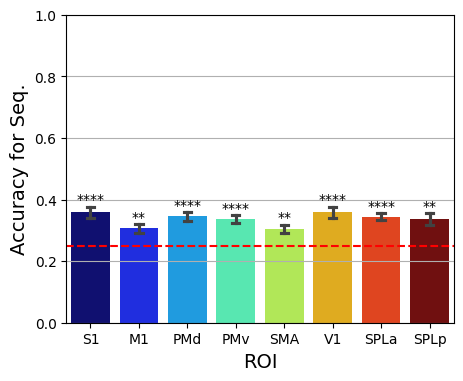

In [25]:
dy = np.diff(ax.get_ylim())*0.025

for ii, roi in enumerate(list_roi):
    a = data[data.roi==roi]['accuracy'].astype(float)
    res = ttest_1samp(a, popmean=chance)
    if res.pvalue < 0.05:
        print(roi, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,su.convert_pval_to_star(res.pvalue)))
        x = ii
        y = a.mean()+a.sem()
        ax.text(
            x=x, y=y,
            s=su.convert_pval_to_star(res.pvalue), fontsize=10,
            ha='center', va='bottom'
        )
fig

### 2. Cue (Support Vector Machine)

In [26]:
labels = reginfo.cue.values
groups = reginfo.run.values
print(len(labels), labels)
print(len(groups), groups)

64 ['L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S'
 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S'
 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S'
 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S' 'L' 'S']
64 [1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 5 5 5 5 5
 5 5 5 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8]


In [27]:
lines = []
for roi in list_roi:
    for sn, subj in enumerate(tqdm(list_subj)):
        sess = subj[0]
        nn = subj[1:]
        
        X = dict_Y[roi][sn].measurements
        nsamples, nfeatures = X.shape
        
        model = SVC(kernel='linear', C=1.0)
        scaler = StandardScaler()
        
        logo = LeaveOneGroupOut()
        nsplits = logo.get_n_splits(X=X, y=labels, groups=groups)
    
        for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X, labels, groups)):
            # print('--- Fold %d/%d ---'%(fold_idx+1,nsplits))
        
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = labels[train_idx], labels[test_idx]
        
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        
            model.fit(X_train_scaled, y_train)
        
            y_pred = model.predict(X_test_scaled)
        
            accuracy = accuracy_score(y_test, y_pred)
            lines.append(
                {'roi':roi,'sess':sess,'subj':nn,'run':fold_idx+1,'accuracy':accuracy}
            )
df_svm = pd.DataFrame(lines)
df_svm

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 38.35it/s]


,roi,sess,subj,run,accuracy
0,S1,S,01,1,0.625
1,S1,S,01,2,0.625
2,S1,S,01,3,0.500
3,S1,S,01,4,0.500
4,S1,S,01,5,0.500
...,...,...,...,...,...
1531,SPLp,R,14,4,1.000
1532,SPLp,R,14,5,0.875
1533,SPLp,R,14,6,1.000
1534,SPLp,R,14,7,1.000


In [30]:
# cmap = cm.jet.resampled(8)
# data = df_svm.groupby(['roi','sess','subj'], as_index=False).mean()

# fig, axs = plt.subplots(ncols=2, figsize=(10,4))
# plt.close()
# for ii, sess in enumerate(['S','R']):
#     ax = axs[ii]
#     g = sns.barplot(
#         data=data[data.sess==sess],
#         x='roi', order=list_roi,
#         y='accuracy',
#         hue='roi', hue_order=list_roi,
#         errorbar='se', capsize=0.15,
#         palette=[cmap(i) for i in range(cmap.N)],
#         ax=ax
#     )
#     g.axhline(y=0.5, color='red', linestyle='--')
#     g.set_ylim(0,1.05)
#     g.grid(axis='y')
#     g.set_ylabel('Accuracy for Cue', fontsize=14)
#     g.set_xlabel('ROI', fontsize=14)
#     g.set_title('sess %s'%sess, fontsize=16)

In [31]:
# dy = np.diff(ax.get_ylim())*0.025

# for ii, roi in enumerate(list_roi):
#     for jj, sess in enumerate(['S','R']):
#         ax = axs[jj]
#         a = data[(data.roi==roi)&(data.sess==sess)]['accuracy'].astype(float)
#         res = ttest_1samp(a, popmean=0.5)
#         if res.pvalue < 0.05:
#             print(roi, sess, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,su.convert_pval_to_star(res.pvalue)))
#             x = ii
#             y = a.mean()+a.sem()
#             ax.text(
#                 x=x, y=y,
#                 s=su.convert_pval_to_star(res.pvalue), fontsize=10,
#                 ha='center', va='bottom'
#             )
# fig

In [28]:
cmap = cm.jet.resampled(8)
data = df_svm.drop('sess',axis=1).groupby(['roi','subj'], as_index=False).mean()

fig, ax = plt.subplots(ncols=1, figsize=(5,4))
plt.close()
g = sns.barplot(
    data=data,
    x='roi', order=list_roi,
    y='accuracy',
    hue='roi', hue_order=list_roi,
    errorbar='se', capsize=0.15,
    palette=[cmap(i) for i in range(cmap.N)],
    ax=ax
)
chance = 0.5
g.axhline(y=chance, color='red', linestyle='--')
g.set_ylim(0,1.05)
g.grid(axis='y')
g.set_ylabel('Accuracy for Cue', fontsize=14)
g.set_xlabel('ROI', fontsize=14)

Text(0.5, 0, 'ROI')

S1 t(11)=7.8445, p=7.869e-06(****)
M1 t(11)=7.0980, p=1.998e-05(****)
PMd t(11)=13.7793, p=2.776e-08(****)
PMv t(11)=13.3043, p=4.001e-08(****)
SMA t(11)=4.8188, p=5.369e-04(***)
V1 t(11)=31.9192, p=3.395e-12(****)
SPLa t(11)=11.1786, p=2.403e-07(****)
SPLp t(11)=18.5922, p=1.168e-09(****)


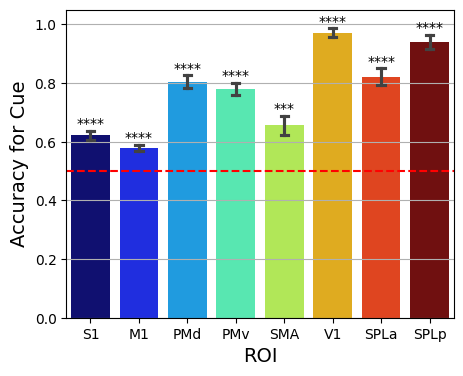

In [29]:
dy = np.diff(ax.get_ylim())*0.025

for ii, roi in enumerate(list_roi):
    a = data[data.roi==roi]['accuracy'].astype(float)
    res = ttest_1samp(a, popmean=chance)
    if res.pvalue < 0.05:
        print(roi, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,su.convert_pval_to_star(res.pvalue)))
        x = ii
        y = a.mean()+a.sem()
        ax.text(
            x=x, y=y,
            s=su.convert_pval_to_star(res.pvalue), fontsize=10,
            ha='center', va='bottom'
        )
fig

### 3. Sequence with Letter (Support Vector Machine)

In [30]:
idx = reginfo.cue.values == 'L'
labels = reginfo.seq.values[idx]
groups = reginfo.run.values[idx]
print(len(labels), labels)
print(len(groups), groups)

32 [1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4]
32 [1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 7 8 8 8 8]


In [31]:
lines = []
for roi in list_roi:
    for sn, subj in enumerate(tqdm(list_subj)):
        sess = subj[0]
        nn = subj[1:]
        
        X = dict_Y[roi][sn].measurements[idx,:]
        nsamples, nfeatures = X.shape
        
        model = SVC(kernel='linear', C=1.0)
        scaler = StandardScaler()
        
        logo = LeaveOneGroupOut()
        nsplits = logo.get_n_splits(X=X, y=labels, groups=groups)
    
        for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X, labels, groups)):
            # print('--- Fold %d/%d ---'%(fold_idx+1,nsplits))
        
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = labels[train_idx], labels[test_idx]
        
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        
            model.fit(X_train_scaled, y_train)
        
            y_pred = model.predict(X_test_scaled)
        
            accuracy = accuracy_score(y_test, y_pred)
            lines.append(
                {'roi':roi,'sess':sess,'subj':nn,'run':fold_idx+1,'accuracy':accuracy}
            )
df_svm = pd.DataFrame(lines)
df_svm

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 48.32it/s]


,roi,sess,subj,run,accuracy
0,S1,S,01,1,0.25
1,S1,S,01,2,0.50
2,S1,S,01,3,0.25
3,S1,S,01,4,0.50
4,S1,S,01,5,0.25
...,...,...,...,...,...
1531,SPLp,R,14,4,0.50
1532,SPLp,R,14,5,0.25
1533,SPLp,R,14,6,0.25
1534,SPLp,R,14,7,0.50


In [32]:
cmap = cm.jet.resampled(8)
data = df_svm.drop('sess',axis=1).groupby(['roi','subj'], as_index=False).mean()

fig, ax = plt.subplots(ncols=1, figsize=(5,4))
plt.close()
g = sns.barplot(
    data=data,
    x='roi', order=list_roi,
    y='accuracy',
    hue='roi', hue_order=list_roi,
    errorbar='se', capsize=0.15,
    palette=[cmap(i) for i in range(cmap.N)],
    ax=ax
)
chance = 0.25
g.axhline(y=chance, color='red', linestyle='--')
g.set_ylim(0,1.05)
g.grid(axis='y')
g.set_ylabel('Accuracy for Seq. with Letter', fontsize=14)
g.set_xlabel('ROI', fontsize=14)

Text(0.5, 0, 'ROI')

S1 t(11)=4.1929, p=1.504e-03(**)
M1 t(11)=4.0588, p=1.887e-03(**)
PMd t(11)=3.6642, p=3.727e-03(**)
PMv t(11)=4.6426, p=7.137e-04(***)
SMA t(11)=3.1485, p=9.267e-03(**)
SPLa t(11)=4.6291, p=7.295e-04(***)
SPLp t(11)=3.0779, p=1.051e-02(*)


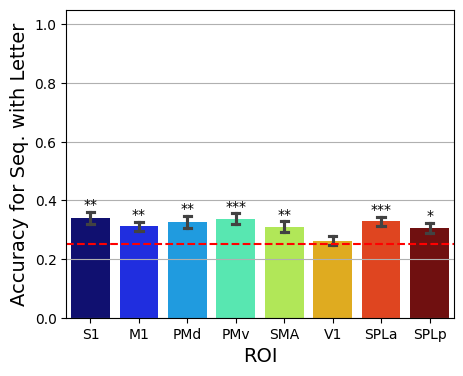

In [33]:
dy = np.diff(ax.get_ylim())*0.025

for ii, roi in enumerate(list_roi):
    a = data[data.roi==roi]['accuracy'].astype(float)
    res = ttest_1samp(a, popmean=chance)
    if res.pvalue < 0.05:
        print(roi, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,su.convert_pval_to_star(res.pvalue)))
        x = ii
        y = a.mean()+a.sem()
        ax.text(
            x=x, y=y,
            s=su.convert_pval_to_star(res.pvalue), fontsize=10,
            ha='center', va='bottom'
        )
fig

### 4. Sequence with Spatial (Support Vector Machine)

In [34]:
idx = reginfo.cue.values == 'S'
labels = reginfo.seq.values[idx]
groups = reginfo.run.values[idx]
print(len(labels), labels)
print(len(groups), groups)

32 [1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4]
32 [1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 7 8 8 8 8]


In [35]:
lines = []
for roi in list_roi:
    for sn, subj in enumerate(tqdm(list_subj)):
        sess = subj[0]
        nn = subj[1:]
        
        X = dict_Y[roi][sn].measurements[idx,:]
        nsamples, nfeatures = X.shape
        
        model = SVC(kernel='linear', C=1.0)
        scaler = StandardScaler()
        
        logo = LeaveOneGroupOut()
        nsplits = logo.get_n_splits(X=X, y=labels, groups=groups)
    
        for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X, labels, groups)):
            # print('--- Fold %d/%d ---'%(fold_idx+1,nsplits))
        
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = labels[train_idx], labels[test_idx]
        
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        
            model.fit(X_train_scaled, y_train)
        
            y_pred = model.predict(X_test_scaled)
        
            accuracy = accuracy_score(y_test, y_pred)
            lines.append(
                {'roi':roi,'sess':sess,'subj':nn,'run':fold_idx+1,'accuracy':accuracy}
            )
df_svm = pd.DataFrame(lines)
df_svm

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 54.25it/s]


,roi,sess,subj,run,accuracy
0,S1,S,01,1,0.25
1,S1,S,01,2,0.25
2,S1,S,01,3,0.75
3,S1,S,01,4,0.25
4,S1,S,01,5,0.50
...,...,...,...,...,...
1531,SPLp,R,14,4,0.50
1532,SPLp,R,14,5,0.50
1533,SPLp,R,14,6,0.25
1534,SPLp,R,14,7,0.25


In [36]:
cmap = cm.jet.resampled(8)
data = df_svm.drop('sess',axis=1).groupby(['roi','subj'], as_index=False).mean()

fig, ax = plt.subplots(ncols=1, figsize=(5,4))
plt.close()
g = sns.barplot(
    data=data,
    x='roi', order=list_roi,
    y='accuracy',
    hue='roi', hue_order=list_roi,
    errorbar='se', capsize=0.15,
    palette=[cmap(i) for i in range(cmap.N)],
    ax=ax
)
chance = 0.25
g.axhline(y=chance, color='red', linestyle='--')
g.set_ylim(0,1.05)
g.grid(axis='y')
g.set_ylabel('Accuracy for Seq. with Spatial', fontsize=14)
g.set_xlabel('ROI', fontsize=14)

Text(0.5, 0, 'ROI')

S1 t(11)=4.4692, p=9.482e-04(***)
M1 t(11)=3.5764, p=4.346e-03(**)
PMd t(11)=4.4159, p=1.036e-03(**)
PMv t(11)=2.7451, p=1.906e-02(*)
SMA t(11)=2.2978, p=4.219e-02(*)
V1 t(11)=6.2704, p=6.084e-05(****)
SPLa t(11)=4.8690, p=4.955e-04(***)
SPLp t(11)=4.5124, p=8.830e-04(***)


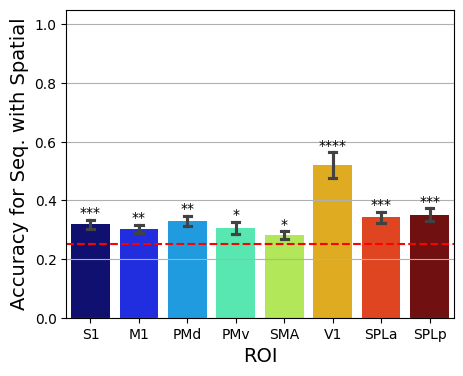

In [37]:
dy = np.diff(ax.get_ylim())*0.025

for ii, roi in enumerate(list_roi):
    a = data[data.roi==roi]['accuracy'].astype(float)
    res = ttest_1samp(a, popmean=chance)
    if res.pvalue < 0.05:
        print(roi, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,su.convert_pval_to_star(res.pvalue)))
        x = ii
        y = a.mean()+a.sem()
        ax.text(
            x=x, y=y,
            s=su.convert_pval_to_star(res.pvalue), fontsize=10,
            ha='center', va='bottom'
        )
fig

### 5. First Finger (Support Vector Machine)

In [38]:
tmp = reginfo.seq - 2.5
reginfo['first'] = ['middle' if x<0 else ('thumb' if x>0 else 'invalid') for x in tmp]
reginfo

,sn,run,cond,regIdx,seq,cue,reg,first
0,1,1,1,1,1,L,"(1,L)",middle
1,1,1,2,2,1,S,"(1,S)",middle
2,1,1,3,3,2,L,"(2,L)",middle
3,1,1,4,4,2,S,"(2,S)",middle
4,1,1,5,5,3,L,"(3,L)",thumb
...,...,...,...,...,...,...,...,...
59,1,8,4,60,2,S,"(2,S)",middle
60,1,8,5,61,3,L,"(3,L)",thumb
61,1,8,6,62,3,S,"(3,S)",thumb
62,1,8,7,63,4,L,"(4,L)",thumb


In [39]:
labels = reginfo['first'].values
groups = reginfo.run.values
print(len(labels), labels)
print(len(groups), groups)

64 ['middle' 'middle' 'middle' 'middle' 'thumb' 'thumb' 'thumb' 'thumb'
 'middle' 'middle' 'middle' 'middle' 'thumb' 'thumb' 'thumb' 'thumb'
 'middle' 'middle' 'middle' 'middle' 'thumb' 'thumb' 'thumb' 'thumb'
 'middle' 'middle' 'middle' 'middle' 'thumb' 'thumb' 'thumb' 'thumb'
 'middle' 'middle' 'middle' 'middle' 'thumb' 'thumb' 'thumb' 'thumb'
 'middle' 'middle' 'middle' 'middle' 'thumb' 'thumb' 'thumb' 'thumb'
 'middle' 'middle' 'middle' 'middle' 'thumb' 'thumb' 'thumb' 'thumb'
 'middle' 'middle' 'middle' 'middle' 'thumb' 'thumb' 'thumb' 'thumb']
64 [1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 5 5 5 5 5
 5 5 5 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8]


In [40]:
lines = []
for roi in list_roi:
    for sn, subj in enumerate(tqdm(list_subj)):
        sess = subj[0]
        nn = subj[1:]
        
        X = dict_Y[roi][sn].measurements
        nsamples, nfeatures = X.shape
        
        model = SVC(kernel='linear', C=1.0)
        scaler = StandardScaler()
        
        logo = LeaveOneGroupOut()
        nsplits = logo.get_n_splits(X=X, y=labels, groups=groups)
    
        for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X, labels, groups)):
            # print('--- Fold %d/%d ---'%(fold_idx+1,nsplits))
        
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = labels[train_idx], labels[test_idx]
        
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        
            model.fit(X_train_scaled, y_train)
        
            y_pred = model.predict(X_test_scaled)
        
            accuracy = accuracy_score(y_test, y_pred)
            lines.append(
                {'roi':roi,'sess':sess,'subj':nn,'run':fold_idx+1,'accuracy':accuracy}
            )
df_svm = pd.DataFrame(lines)
df_svm

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 35.60it/s]


,roi,sess,subj,run,accuracy
0,S1,S,01,1,0.500
1,S1,S,01,2,0.625
2,S1,S,01,3,0.500
3,S1,S,01,4,0.500
4,S1,S,01,5,0.625
...,...,...,...,...,...
1531,SPLp,R,14,4,0.500
1532,SPLp,R,14,5,0.500
1533,SPLp,R,14,6,0.500
1534,SPLp,R,14,7,0.625


In [41]:
cmap = cm.jet.resampled(8)
data = df_svm.drop('sess',axis=1).groupby(['roi','subj'], as_index=False).mean()

fig, ax = plt.subplots(ncols=1, figsize=(5,4))
plt.close()
g = sns.barplot(
    data=data,
    x='roi', order=list_roi,
    y='accuracy',
    hue='roi', hue_order=list_roi,
    errorbar='se', capsize=0.15,
    palette=[cmap(i) for i in range(cmap.N)],
    ax=ax
)
chance = 0.5
g.axhline(y=chance, color='red', linestyle='--')
g.set_ylim(0,1.05)
g.grid(axis='y')
g.set_ylabel('Accuracy for First finger', fontsize=14)
g.set_xlabel('ROI', fontsize=14)

Text(0.5, 0, 'ROI')

S1 t(11)=5.0322, p=3.826e-04(***)
M1 t(11)=3.8208, p=2.839e-03(**)
PMd t(11)=4.8413, p=5.179e-04(***)
PMv t(11)=5.4149, p=2.118e-04(***)
SMA t(11)=6.7823, p=3.024e-05(****)
V1 t(11)=7.5091, p=1.186e-05(****)
SPLa t(11)=6.6017, p=3.855e-05(****)
SPLp t(11)=4.1881, p=1.516e-03(**)


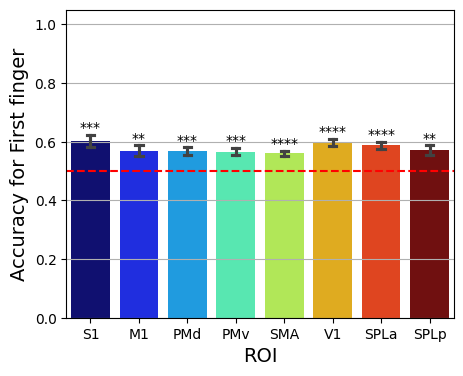

In [42]:
dy = np.diff(ax.get_ylim())*0.025

for ii, roi in enumerate(list_roi):
    a = data[data.roi==roi]['accuracy'].astype(float)
    res = ttest_1samp(a, popmean=chance)
    if res.pvalue < 0.05:
        print(roi, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,su.convert_pval_to_star(res.pvalue)))
        x = ii
        y = a.mean()+a.sem()
        ax.text(
            x=x, y=y,
            s=su.convert_pval_to_star(res.pvalue), fontsize=10,
            ha='center', va='bottom'
        )
fig

### 3. Linear Discriminant Analysis

In [47]:
# fig.savefig(
#     join(dir_work,'glm_%d.G_hat.ROIs.correlation.png'%glm),
#     dpi=300, facecolor=[1,1,1,1],
#     bbox_inches='tight'
# )

---